### Load packages

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import h5py

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from aste_helper_funcs import *

### Define filenames and sizing

In [2]:
dirroot = "/scratch2/atnguyen/aste_270x450x180/"
dirRun = "/scratch/atnguyen/aste_270x450x180/OFFICIAL_ASTE_R1_Sep2019/"
dirDiags = dirRun + "diags/"
dirState = dirDiags + "STATE/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
dirgridw = dirroot + "GRID_wet/"

In [3]:
bigaste = True    # set up something to trigger in case we run with either big or little

if bigaste:
    nx = 270
    ncut1 = 450
    ncut2 = 180
else:
    nx = 90
    ncut1 = 150
    ncut2 = 60
    
ny = 2*ncut1+nx+ncut2
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

### Define the Grid

In [4]:
mygrid = {
    'dirGrid': dirgrid,
    'nFaces': 5,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','RAC','Depth'] #  ,'DXG','DYG','DXC','DYC'] # 'XG','YG'
fldstr3d = ['hFacC'] #,'hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC'] # ,'hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','DRF'] # ,'RF','DRC',

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirgrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirgrid, fldstr3dp[fldstr3d.index(fld)]))
    print(temp.shape)
    print(temp.reshape(nz, ny, nx).shape)
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirgrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

(50, 4050, 90)
(50, 1350, 270)


In [5]:
# obcs
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z

print("hf1",hf1.shape)
# hf1 = hf1[np.newaxis,:, :]
hf1.shape

hf1 = get_aste_tracer(hf1, nfx, nfy)

# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

print(hf.shape,hf1.shape)

hf1 (1350, 270)
SZ! (1, 900, 540)
shape of fld: (1, 900, 540)
(1, 270, 270)
(1, 270, 180)
(1, 270, 450)
(1, 1350, 270)
compact shape (1, 1350, 270)
(50, 1350, 270) (1, 1350, 270)


In [6]:
# 2d
inf = h5py.File(dirgridw + 'Index_wet_hfacC_2D.mat')
arr = inf['ind'][:]
iwetC2d = arr[5,:]
iwetC2d = iwetC2d.astype("int32")
iwetC2d -= 1
LwetC2d = iwetC2d.shape[0]
print("LwetC2d",LwetC2d)

# 3d
inf = h5py.File(dirgridw + "Index_wet_hfacC.mat")
arr = inf['ind'][:]
iwetC = arr[5,:]
iwetC = iwetC.astype("int32")
LwetC = iwetC.shape[0]
print("LwetC",LwetC)

# 2d
rac2d = read_float64(dirgridw + "RAC_" + str(LwetC2d) + ".data")
# TEST, ask An
# rac2d = rac2d.reshape((LwetC2d,2))
# rac2d = rac2d[:,0]
print("RAC2d",rac2d.shape)

# 3d
drf3d = read_float32(dirgridw + "DRF_" + str(LwetC) + ".data")

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat[iwetC2d]

# hf.shape - z, y, x
# hf1.shape - 1, y, x
hfflat = np.reshape(hf,hf.flatten().shape[0])
hf3d = hfflat[iwetC]

LwetC2d 146614
LwetC 4833023
RAC2d (146614,)


### Create a mask of the wet points for the rest of the data - compact shape

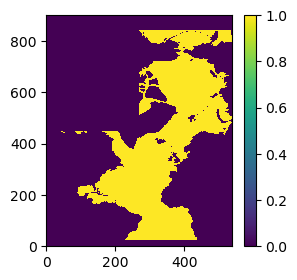

In [29]:
wetmask = np.zeros((ny*nx))
wetmask[iwetC2d[np.where(hf2d>0)[0]]] = 1
wetmask =  np.reshape(wetmask,(ny,nx))
wetmaskplt = get_aste_tracer(wetmask,nfx,nfy)
# wetmaskplt = wetmaskplt.reshape(nfy[0]+nx+nfx[3],2*nx)
wetmaskplt = wetmaskplt.reshape(wetmaskplt.shape[1],wetmaskplt.shape[2])
plt.figure(figsize=(3,3))
plt.pcolormesh(wetmaskplt)
plt.colorbar()

### Read in the file - create xr

In [11]:
# I think one file is __ time
fileTS = rdmds(dirState + "/state_3d_set1",4464)
fldListTS = parsemeta(dirState + "state_3d_set1.0000004464.meta")["fldList"]
print(fldListTS)
fileTS = fileTS.reshape(2,nz, ny, nx)
fileTS.shape  # compact form

['THETA', 'SALT']


(2, 50, 1350, 270)

In [32]:
# we want to mask our values with nan based on the wet points first- this will help with binning
wetmask[wetmask == 0] = np.nan

In [12]:
# remember that in order to plot this we have to use get_aste_tracer on the 1350 x 270 array
# this will give us the array that we can plot

In [34]:
dims = ("z","compact_x","compact_y")
coords = {"z" : np.arange(0,50,1),
          "compact_x" : np.arange(0,1350,1),
          "compact_y" : np.arange(0,270,1)}

attrsT = {'title' : 'T data from state_3d_set1 example from official ASTE',
         'standard_name' : 'temperature',
         'units' : 'degree_c'}

attrsS = {'title' : 'S data from state_3d_set1 example from official ASTE',
         'standard_name' : 'temperature',
         'units' : 'ppt'}

In [35]:
temp = xr.DataArray(data = fileTS[0,:,:,:]*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsT)

salt = xr.DataArray(data = fileTS[1,:,:,:]*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsS)

In [36]:
ds = xr.Dataset({'theta': temp, 'salinity': salt})

In [37]:
ds

<xarray.Dataset>
Dimensions:    (z: 50, compact_x: 1350, compact_y: 270)
Coordinates:
  * z          (z) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * compact_x  (compact_x) int64 0 1 2 3 4 5 6 ... 1344 1345 1346 1347 1348 1349
  * compact_y  (compact_y) int64 0 1 2 3 4 5 6 7 ... 263 264 265 266 267 268 269
Data variables:
    theta      (z, compact_x, compact_y) float64 nan nan nan nan ... nan nan nan
    salinity   (z, compact_x, compact_y) float64 nan nan nan nan ... nan nan nan

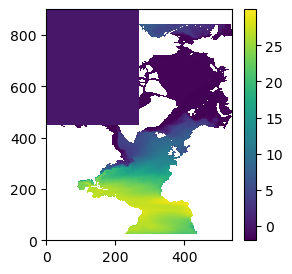

In [73]:
# test plot to make sure we are doing this correctly
fig = plt.figure(figsize=(3,3))
plt.pcolormesh(get_aste_tracer(temp[0,:,:].values,nfx,nfy)[0,:,:])
plt.colorbar()

### Grab the TS bins

In [63]:
dirrun_small = "/scratch2/atnguyen/aste_270x450x180/run_c67w_layers_budget_nlayersorig_advdiffsplit_FULLYfixedXX_checkedwithAN_it0062_nS112_nT112_pk0000631152/"

binsTH = rdmds(dirrun_small + "layers2TH", -1)
binsTH_edges = binsTH[:,:,0].flatten()
binsTS_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2

binsSLT = rdmds(dirrun_small + "layers1SLT", -1)
binsSLT_edges = binsSLT[:,:,0].flatten()
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2

In [66]:
# let's create a binning function with numpy
def bin_array(arr, bin_edges):
    flattened_arr = arr.flatten()
    bin_indices = np.digitize(flattened_arr, bin_edges)
    bin_indices_3d = bin_indices.reshape(arr.shape)
    
    return bin_indices_3d

In [67]:
# create this as an xarray and add it to the dataset
binned_theta = bin_array(ds.theta.values,binsTH_edges)
binned_salinity = bin_array(ds.salinity.values,binsSLT_edges)

binned_temp = xr.DataArray(data = binned_theta*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsT)

binned_salt = xr.DataArray(data = binned_salinity*wetmask,
                    dims = dims,
                    coords = coords,
                    attrs = attrsS)

In [68]:
ds["theta_binned"] = binned_temp
ds["salinity_binned"] = binned_salt

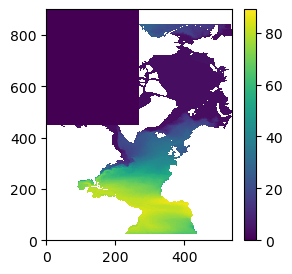

In [74]:
fig = plt.figure(figsize=(3,3))
plt.pcolormesh(get_aste_tracer(binned_temp[0,:,:].values,nfx,nfy)[0,:,:])
plt.colorbar()

### Great, now we binned the values. Can we get the volume per cell?

In [76]:
binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)

In [97]:
# the volume will just be based on the grid cell in the model
# we need the actual distance width, height, and depth of the model cells
longitude = mygrid["XC"]   # longitude
latitude = mygrid["YC"]   # latitude
depth = mygrid['Depth']   # compact form

In [ ]:
# if we calculate distances it will be one less than x and y in both directions, also get_aste_tracer

In [ ]:
vol_distrib = {}